In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('lib')
from lib.read_data import *
import time

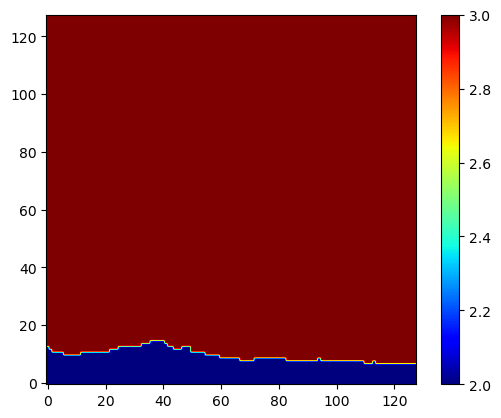

In [3]:
N = 128
frame = 100
flags = read_flags(f"data/dambreak_N{N}_200/flags_{frame}.bin")

rhs = load_vector(f"data/dambreak_N{N}_200/div_v_star_{frame}.bin")


plt.imshow(flags.reshape(N, N).T, cmap='jet', origin='lower')
plt.colorbar()
plt.show()

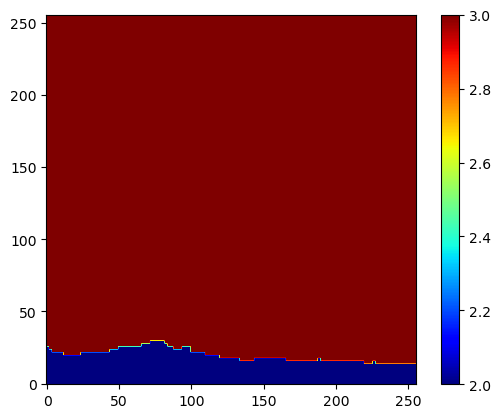

In [7]:
scale = 2
flags_up = flags.reshape(N,N).repeat(scale, axis=0).repeat(scale, axis=1)

plt.imshow(flags_up.reshape(N*scale, N*scale).T, cmap='jet', origin='lower')
plt.colorbar()
plt.show()

In [11]:
fluids = np.argwhere(flags_up.ravel() == 2).ravel()
fluids

array([    0,     1,     2, ..., 65291, 65292, 65293])